In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

# 1. Подготовка данных

В качестве целевой переменной берем столбец `total_cases`. В качестве трейна берем первые 50 дней, начиная с 3 марта 2020, для теста берем следующие после трейна 100 дней. Было решено не брать все оставшиеся дни для теста, потому что в этом нет смысла, так как в будущем будет еще несколько пиков роста заболеваемости, которые нельзя описать, располагая только данными на перве 50 дней.

In [2]:
data_all = pd.read_csv('owid-covid-data.csv')
data = data_all.copy()

In [3]:
data = data[data['location'] == 'Russia']
data.date = pd.to_datetime(data.date)
data = data[data.date >= pd.to_datetime('2020-03-03')]
total_cases = data['total_cases'].values
new_cases = data['new_cases'].apply(lambda x: x + 1 if x == 0 else x).values.astype(int)
x = np.arange(1, total_cases.shape[0] + 1, dtype=float).reshape(-1, 1)
dates = data.date.values

total_cases_train = total_cases[:50]
new_cases_train = new_cases[:50]
x_train = x[:50]
dates_train = dates[:50]

n = 150
total_cases_test = total_cases[50:n]
new_cases_test = new_cases[50:n]
x_test = x[50:n]
dates_test = dates[50:n]

# 2. Экспоненциальная модель

Построим графики целевых переменных на трейне и тесте.

In [4]:
def plot_target(x, y, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y)
    plt.title(title, fontsize=20)
    plt.xlabel('day', fontsize=15)
    plt.ylabel(title, fontsize=15)
    plt.grid()

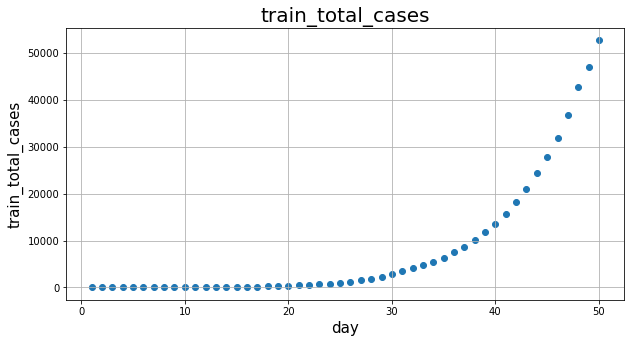

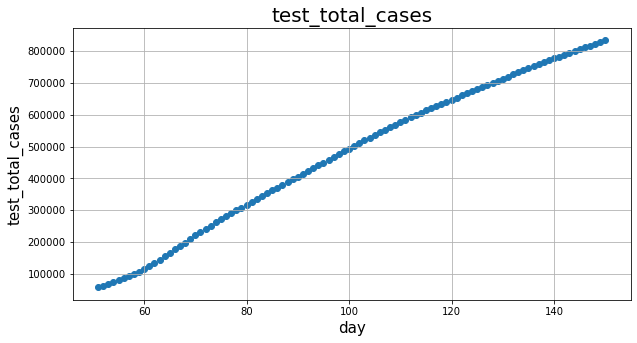

In [5]:
plot_target(x_train, total_cases_train, 'train_total_cases')
plot_target(x_test, total_cases_test, 'test_total_cases')

### 2.1 Обучение линейной регрессии.

Обучим модель с экспоненциальным ростом числа заболевших:

$$
y = exp(w_0 + x*w_1)
$$

$$
y - \text{число заболевших} \\
x - \text{номер текущего дня}
$$

Для этого возвмем логарифм от правой и левой частей выражения:

$$
ln(y) = ln(exp(w_0 + x*w_1)) \\
ln(y) = w_0 + x*w_1
$$

Таким образом, необходимо обучить обычную линейную регрессию на предсказание $ln(y)$.


In [6]:
model_exp = LinearRegression().fit(x_train, np.log(total_cases_train))

In [7]:
pred_train_exp = np.exp(model_exp.predict((x_train)))
pred_test_exp = np.exp(model_exp.predict((x_test)))

In [8]:
def plot_target_model(x, y, pred, title):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for i in range(2):
        if i == 0:
            ax[i].set_title(title, fontsize=20)
            ax[i].scatter(x, y, label='true values', c='b')
            ax[i].plot(x, pred, label='prediction', c='r')
        else:
            ax[i].set_title(title + '_log_scale', fontsize=20)
            ax[i].scatter(x, np.log(y), label='true values', c='b')
            ax[i].plot(x, np.log(pred), label='prediction', c='r')
        ax[i].set_ylabel(title, fontsize=15)
        ax[i].set_xlabel('day', fontsize=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)

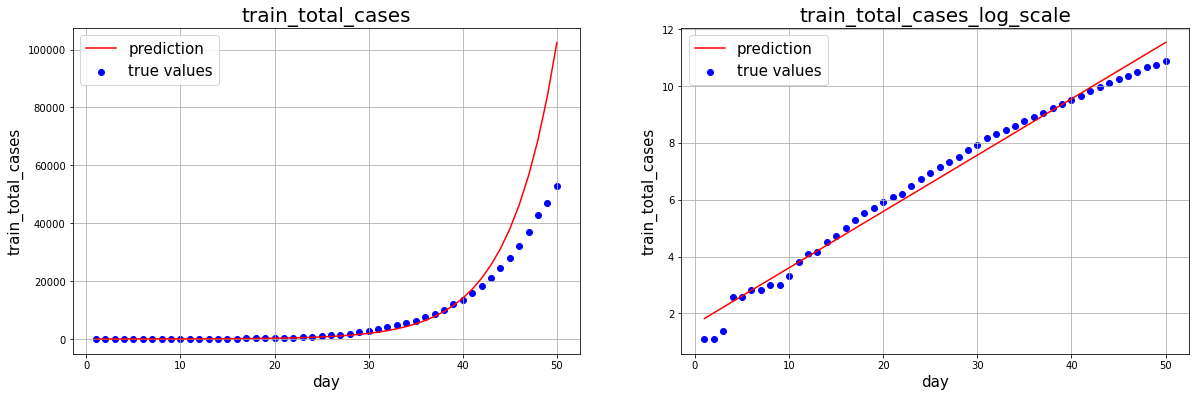

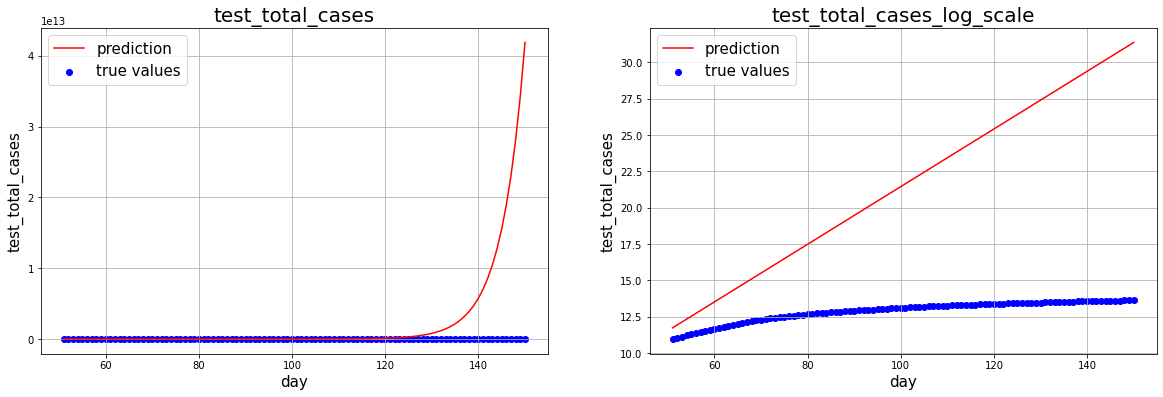

In [9]:
plot_target_model(x_train, total_cases_train, pred_train_exp, 'train_total_cases')
plot_target_model(x_test, total_cases_test, pred_test_exp, 'test_total_cases')

Видно, что модель на небольших $x$ неплохо описывает данные, однако дальше экспоненциально растет и совершенно не соотносится с данными, особенно на тесте.

### 2.2 Поиск апостериорного распределения.

Апостериорное распределение задается как произведение априорного распределния и правдоподобия, поэтому сначала определим их.

Априорное распределение зададим как нормальное распределение с параметрами:

$$
\mu = 0 \\
\Sigma = \begin{bmatrix}5 & 0 \\ 0 & 5 \end{bmatrix}
$$

In [10]:
proir_mu = np.array([0, 0]) 
proir_sigma = 5 * np.array([[1, 0], [0, 1]])
w_0 = model_exp.intercept_
w_1 = model_exp.coef_[0]
z_model_exp = multivariate_normal.pdf([w_0, w_1], mean=proir_mu, cov=proir_sigma)
print(f'Вероятность весов модели в соотвествии с априорным распределением: {z_model_exp:.5f}')

Вероятность весов модели в соотвествии с априорным распределением: 0.02437


Посэмплируем прямые из этого априорного распределения.

In [11]:
def sample_lines(mu, sigma, x, y, limits, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for i in range(2):
        if i == 0:
            ax[i].scatter(x, y, label='true values')
            ax[i].set_ylim(0, limits[0])
            ax[i].set_title('sampled_from_prior', fontsize=20)
            for w in my_w:
                ax[i].plot(x, np.exp(w[0] + w[1]*x), 'k-', lw=0.5)
        else:
            ax[i].scatter(x, np.log(y), label='true values')
            ax[i].set_ylim(0, limits[1])
            ax[i].set_title('sampled_from_prior_log_scale', fontsize=20)
            for w in my_w:
                ax[i].plot(x, w[0] + w[1]*x, 'k-', lw=0.5)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel('y', fontsize=15)
        ax[i].grid()
        ax[i].legend(loc='upper right')

<Figure size 864x432 with 0 Axes>

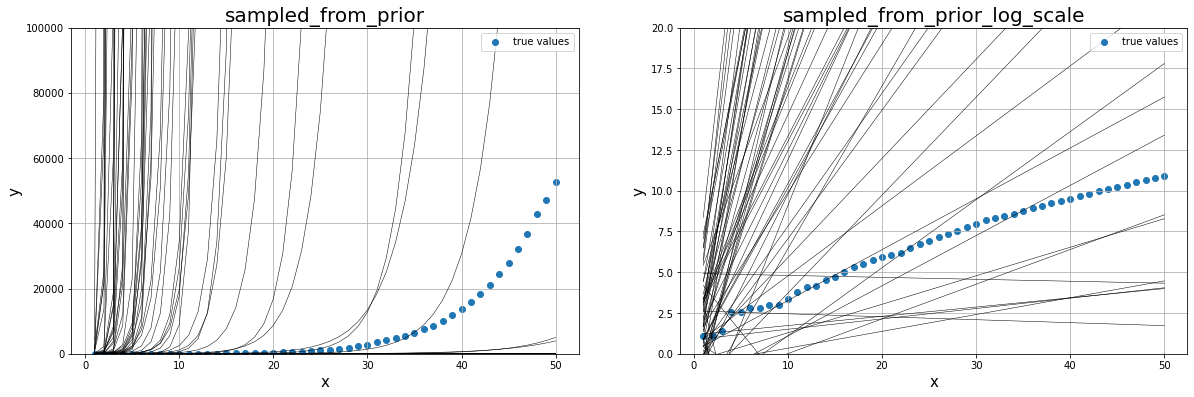

In [12]:
limits = [1e5, 20]
plt.figure(figsize=(12, 6))
sample_lines(proir_mu, proir_sigma, x_train, total_cases_train, limits, 100)

Получаем какой-то набор экспонент никак не соотносящихся с данными. Правдоподобие $i$-го объекта тоже зададим нормальным распределением с параметрами:

$$
\mu = w_0 + w_1x_i\\
\sigma^2 - \text{дисперсия шума, которую можно оценить, используя обученную модель}
$$

Дисперсию необходимо оценивать в логарифмической шкале, так как наша линейная модель предсказывает $ln(y)$.

In [13]:
std_noise = np.std(np.log(total_cases_train) - np.log(pred_train_exp))
print(f'Дисперсия шума: {std_noise ** 2}')

Дисперсия шума: 0.12183046154391239


Теперь путем перемножения априорного распределения и правдоподобия всех точек датасета получим параметры апостериорного распределения.

In [14]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x[0]]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.log(np.array([y]))))
    return mu_n, sigma_n

In [15]:
post_mu, post_sigma = proir_mu, proir_sigma.copy()
for x, y in zip(x_train, total_cases_train):
    post_mu, post_sigma = bayesian_update(post_mu, post_sigma, x, y, std_noise)

In [16]:
print(f'Параметры обученной модели: \n w_0 = {w_0:.4f} \n w_1 = {w_1:.4f} \n\n')
print(f'Параметры апостериорного распределения (MAP): \n w_0 = {post_mu[0]:.4f} \n w_1 = {post_mu[1]:.4f}')

Параметры обученной модели: 
 w_0 = 1.6224 
 w_1 = 0.1983 


Параметры апостериорного распределения (MAP): 
 w_0 = 1.6192 
 w_1 = 0.1984


Параметры модели и МАР достаточно хорошо соотносятся.

### 2.3 Предсказательное распределение 

Теперь посемплируем множество экспонент из получившегося распределения. MAP апостериорного распределения является $\mu$, так как мы взяли нормальное распределение в качестве апостериорного.

In [17]:
def sample_from_posterior(mu, sigma, x, y, pred, limits, title, dates=None, n=20):
    if dates is not None:
        x_axis = dates
    else:
        x_axis = x
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(22, 7))
    for i in range(2):
        if i == 0:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, np.exp(w[0] + w[1]*x), 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, np.exp(w[0] + w[1]*x), 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, y, label='true values')
            ax[i].plot(x_axis, pred, c='r', label='model prediction')
            ax[i].plot(x_axis, np.exp(mu[0] + mu[1]*x), c='orange', label='MAP')
            ax[i].set_ylim(0, limits[0])
            ax[i].set_title('sampled_from_posterior', fontsize=20)
        else:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, w[0] + w[1]*x, 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, w[0] + w[1]*x, 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, np.log(y), label='true values')
            ax[i].plot(x_axis, np.log(pred), c='r', label='model prediction')
            ax[i].plot(x_axis, mu[0] + mu[1]*x, c='orange', label='MAP')
            ax[i].set_ylim(0, limits[1])
            ax[i].set_title('sampled_from_posterior_log_scale', fontsize=20)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel(title, fontsize=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)

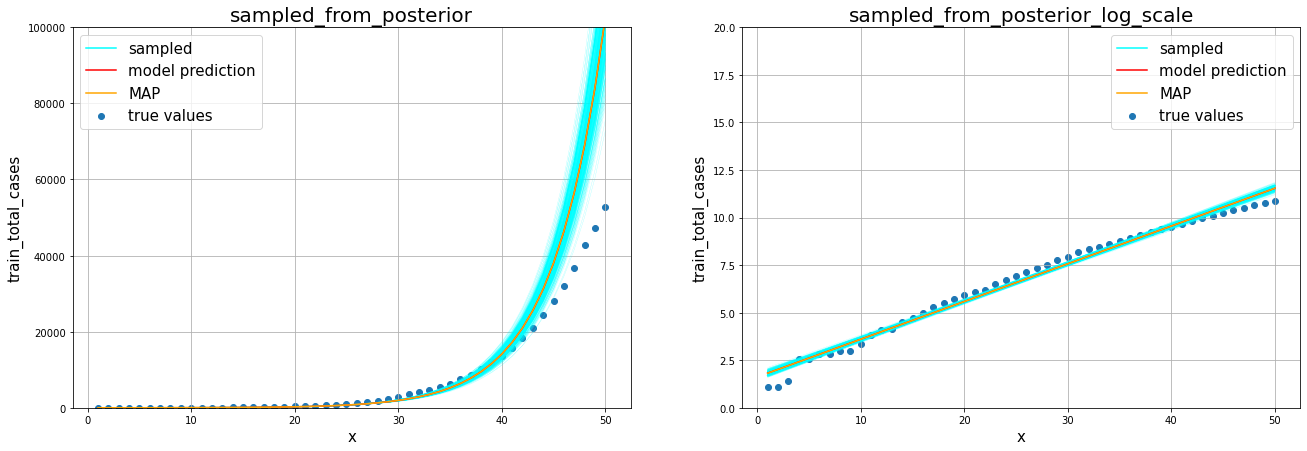

In [18]:
limits = [1e5, 20]
sample_from_posterior(post_mu, post_sigma, x_train, total_cases_train, pred_train_exp, limits, 'train_total_cases', n=400)

Таким образом, мы получили апостериорное распределение с МАР, совпадающим с обученной моделью. Также видно, что с увеличением $x$ увеличивается разброс $y$, то есть модель меньше уверена в предсказаниях.

Теперь попробуем сделать предсказания, для этого сэмплируем экспоненты и на них сделаем предсказания на тесте.

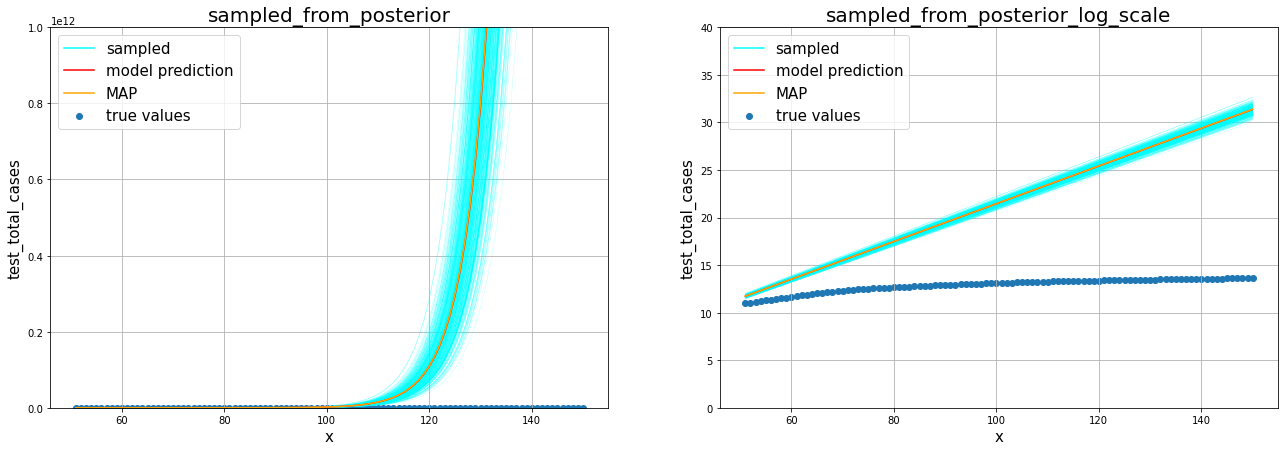

In [19]:
limits = [1e12, 40]
sample_from_posterior(post_mu, post_sigma, x_test, total_cases_test, pred_test_exp, limits, 'test_total_cases', n=400)

Очевидно, что здесь ситуация будет такой же плачевной, как и с обученной моделью. Экспоненциальная модель, которую мы предположили, обладает плохой предсказательной способностью.

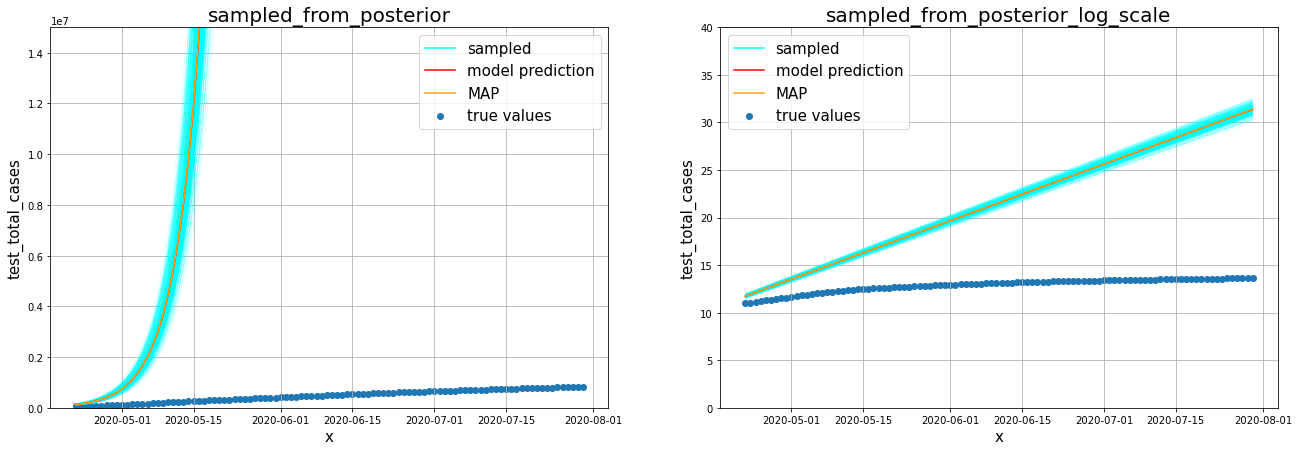

In [20]:
limits = [1.5e7, 40]
sample_from_posterior(post_mu, post_sigma, x_test, total_cases_test, pred_test_exp, 
                      limits, 'test_total_cases', dates=dates_test, n=400)

Если посмотрим, что предсказывает модель на начало мая/июня, то увидим, что там какие-то заоблачные цифры, которые в принципе превышают численность населения России.

# 3. Сигмоидальная модель.

По сути, сигмоида, которую мы выбрали, представляет собой кумулятивную сумму значений экспоненты квадратичной функции. В нашем случае сигмоидой должна описываться переменная `total_cases`. Она совершенно очевидно представляет из себя кумулятивную сумму значений `new_cases`, т.е. чтобы получить сигмоидальную функции общего числа зараженных, необходимо обучить линейную регрессию с таргетом `new_cases`. Модель будет иметь вид:

$$
y_{new\_cases} = exp(w_0 + x*w_1 + x^2*w_2) \\ 
ln(y_{new\_cases}) = ln(exp(w_0 + x*w_1 + x^2*w_2)) \\
ln(y_{new\_cases}) = w_0 + x*w_1 + x^2*w_2
$$

Таким образом, $y_{new\_cases}$ представляет из себя экспоненту квадратичной функции от $x$.

Стоит уточнить, что в самом начале мы заменили все 0 для `new_cases` на 1, это привело к тому, что кумулятивная сумма `new_cases` и реальные значения `total_cases` не будут совпадать, однако отклонение очень незначительно, поэтому предлагаю не пересчитывать `total_cases`.

### 3.1 Обучение сигмоидальной функции.

Рассмотрим распределение таргета `new_cases`.

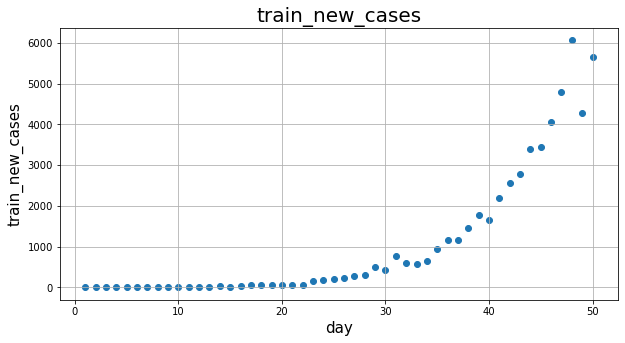

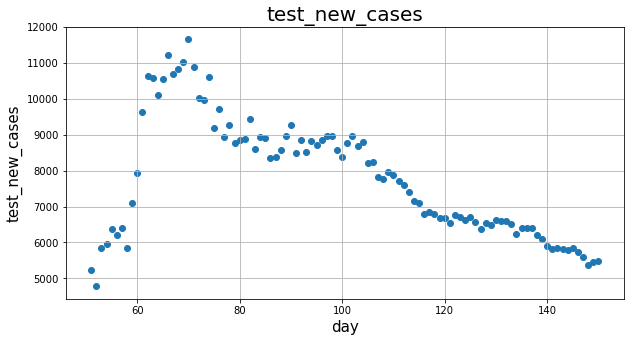

In [21]:
plot_target(x_train, new_cases_train, 'train_new_cases')
plot_target(x_test, new_cases_test, 'test_new_cases')

In [22]:
x_train_sigma = np.hstack((x_train, x_train ** 2))
x_test_sigma = np.hstack((x_test, x_test ** 2))

In [23]:
model_sigma = LinearRegression().fit(x_train_sigma, np.log(new_cases_train))

In [24]:
pred_train_sigma = np.exp(model_sigma.predict((x_train_sigma)))
pred_test_sigma = np.exp(model_sigma.predict((x_test_sigma)))

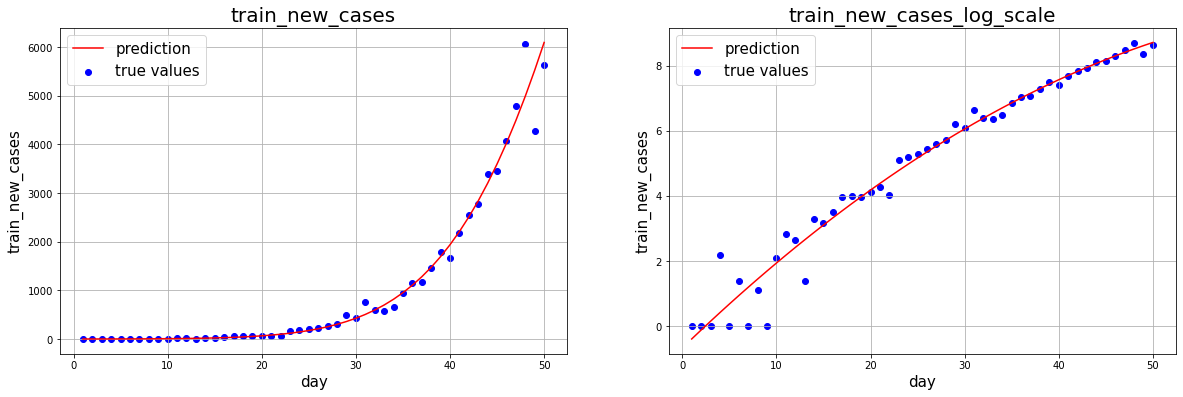

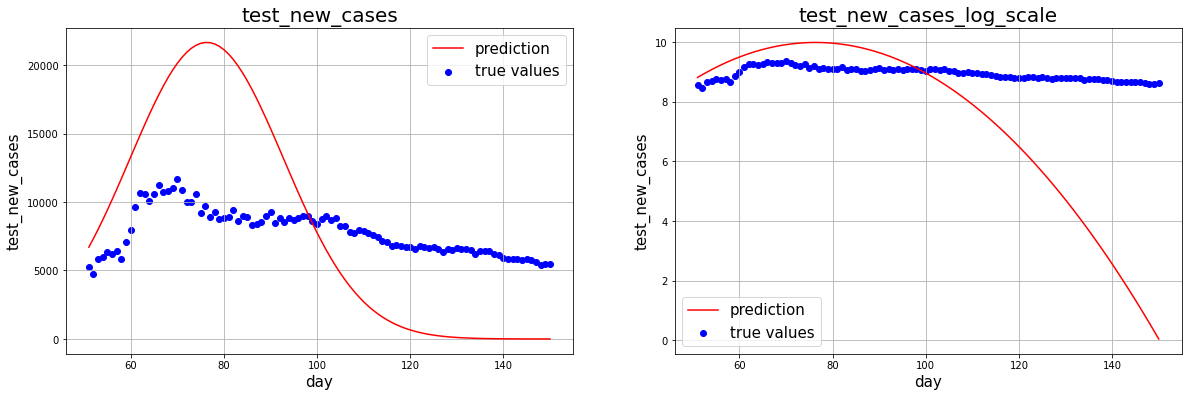

In [25]:
plot_target_model(x_train[:, 0], new_cases_train, pred_train_sigma, 'train_new_cases')
plot_target_model(x_test[:, 0], new_cases_test, pred_test_sigma, 'test_new_cases')

Полученная модель хорошо описывает обучающую выборку и на тесте мы видим, что функция имеет форму холмика. Это согласуется с тем, что на начальных этапах эпидемии число новых заболевших растет, достигает пика и потом идет на спад. Модель не идеально, но описывает эту тенденцию. Теперь рассмотрим `total_cases`.

In [26]:
pred_train_sigma_total = np.cumsum(pred_train_sigma)
pred_test_sigma_total = np.cumsum(pred_test_sigma)

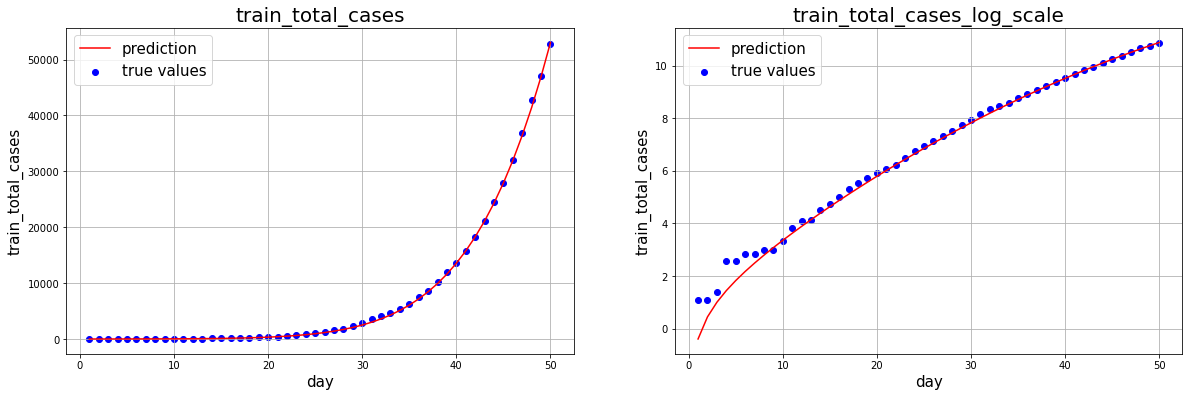

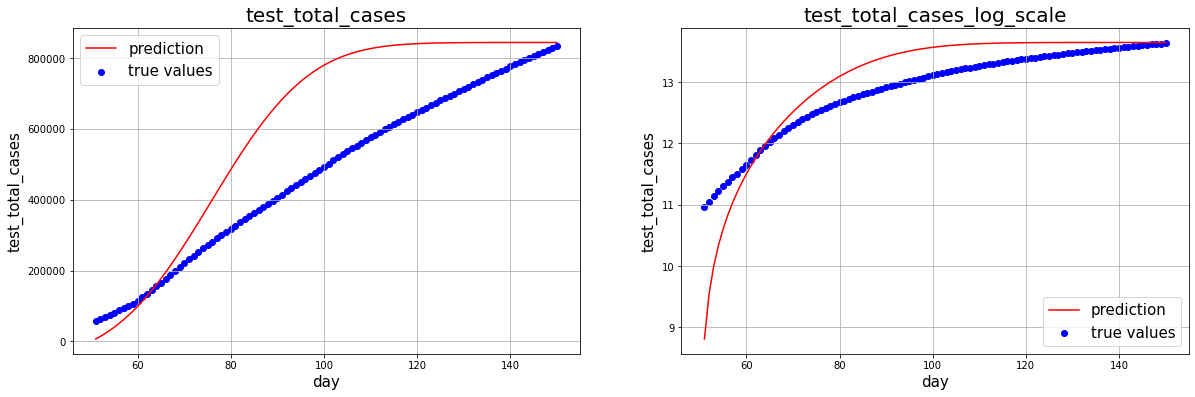

In [27]:
plot_target_model(x_train[:, 0], total_cases_train, pred_train_sigma_total, 'train_total_cases')
plot_target_model(x_test[:, 0], total_cases_test, pred_test_sigma_total, 'test_total_cases')

Сравним полученные результаты с результатами экспоненциальной модели. Во-первых, модель идеально описывает трейновую выборку, во-вторых, мы получаем сигмоиду, которая лучше описывает динамику роста заболевших на тесте. Конечно, если мы возьмем еще на 100 дней вперед, сигмоида останется на плато, а число заболевших будет расти (следующие волны), однако данная модель оценивается в перделах одной волны.

# 3.2 Поиск апостериорного распределения.

Процесс поиска апостериорного распределения идентичен этому процессу для экспоненциальной модели, единственное различие в том, что здесь мы аппроксимируем модель для `new_cases`, а уже потом получаем распределение для `total_cases`.

Априорное распределение зададим как нормальное распределение с теми же параметрами, но уже трехмерное.

In [28]:
proir_mu = np.array([0, 0, 0]) 
proir_sigma = 5 * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
w_0 = model_sigma.intercept_
w_1, w_2 = model_sigma.coef_
z_model_sigma = multivariate_normal.pdf([w_0, w_1, w_2], mean=proir_mu, cov=proir_sigma)
print(f'Вероятность весов модели в соотвествии с априорным распределением: {z_model_sigma:.5f}')

Вероятность весов модели в соотвествии с априорным распределением: 0.00538


Можем так же посемплировать из этого распределения.

<Figure size 864x432 with 0 Axes>

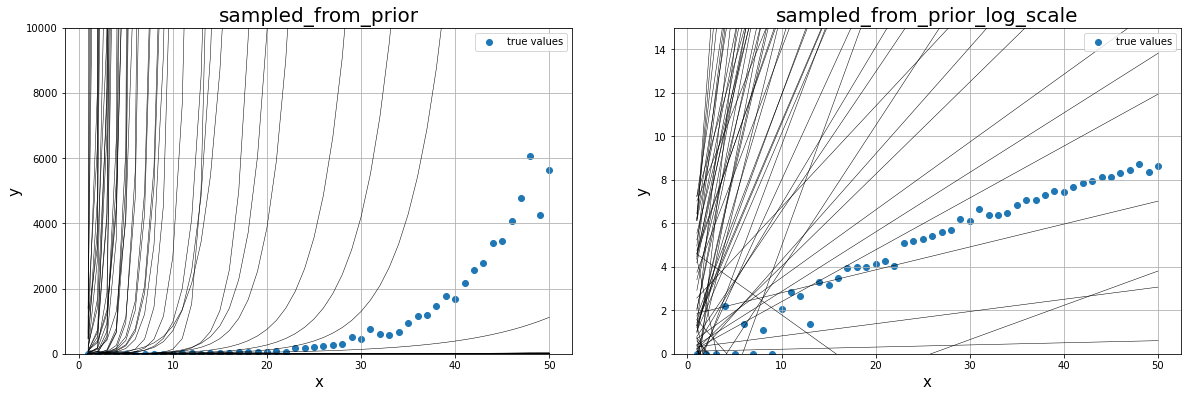

In [29]:
limits = [1e4, 15]
plt.figure(figsize=(12, 6))
sample_lines(proir_mu, proir_sigma, x_train, new_cases_train, limits, 100)

Таким же образом оцениваем дисперсию шума.

In [30]:
std_noise = np.std(np.log(new_cases_train) - np.log(pred_train_sigma))
print(f'Дисперсия шума: {std_noise ** 2}')

Дисперсия шума: 0.23928684127005564


Теперь путем перемножения априорного распределения и правдоподобия всех точек датасета получим параметры апостериорного распределения.

In [31]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x[0], x[0]**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.log(np.array([y]))))
    return mu_n, sigma_n

In [32]:
post_mu, post_sigma = proir_mu, proir_sigma.copy()
for x, y in zip(x_train, new_cases_train):
    post_mu, post_sigma = bayesian_update(post_mu, post_sigma, x, y, std_noise)

In [33]:
print(f'Параметры обученной модели: \n w_0 = {w_0:.4f} \n w_1 = {w_1:.4f} \n w_2 = {w_2:.4f}\n\n')
print(f'Параметры апостериорного распределения (MAP): \n w_0 = {post_mu[0]:.4f} \n w_1 = {post_mu[1]:.4f} \n w_2 = {post_mu[2]:.4f}')

Параметры обученной модели: 
 w_0 = -0.6740 
 w_1 = 0.2793 
 w_2 = -0.0018


Параметры апостериорного распределения (MAP): 
 w_0 = -0.6676 
 w_1 = 0.2788 
 w_2 = -0.0018


Параметры модели и МАР достаточно хорошо соотносятся.

### 3.3 Предсказательное распределение 

Теперь посемплируем множество экспонент из получившегося распределения. MAP апостериорного распределения является  𝜇 , так как мы взяли нормальное распределение в качестве апостериорного.

In [34]:
def sample_from_posterior_new_cases(mu, sigma, x, y, pred, limits, title, dates=None, n=20):
    if dates is not None:
        x_axis = dates
    else:
        x_axis = x
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(22, 7))
    for i in range(2):
        if i == 0:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, np.exp(w[0] + w[1]*x + w[2]*x**2), 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, np.exp(w[0] + w[1]*x + w[2]*x**2), 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, y, label='true values')
            ax[i].plot(x_axis, pred, c='r', label='model prediction')
            ax[i].plot(x_axis, np.exp(mu[0] + mu[1]*x + mu[2]*x**2), c='orange', label='MAP')
            ax[i].set_ylim(0, limits[0])
            ax[i].set_title('sampled_from_posterior', fontsize=20)
        else:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, w[0] + w[1]*x + w[2]*x**2, 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, w[0] + w[1]*x + w[2]*x**2, 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, np.log(y), label='true values')
            ax[i].plot(x_axis, np.log(pred), c='r', label='model prediction')
            ax[i].plot(x_axis, mu[0] + mu[1]*x + mu[2]*x**2, c='orange', label='MAP')
            ax[i].set_ylim(0, limits[1])
            ax[i].set_title('sampled_from_posterior_log_scale', fontsize=20)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel(title, fontsize=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)

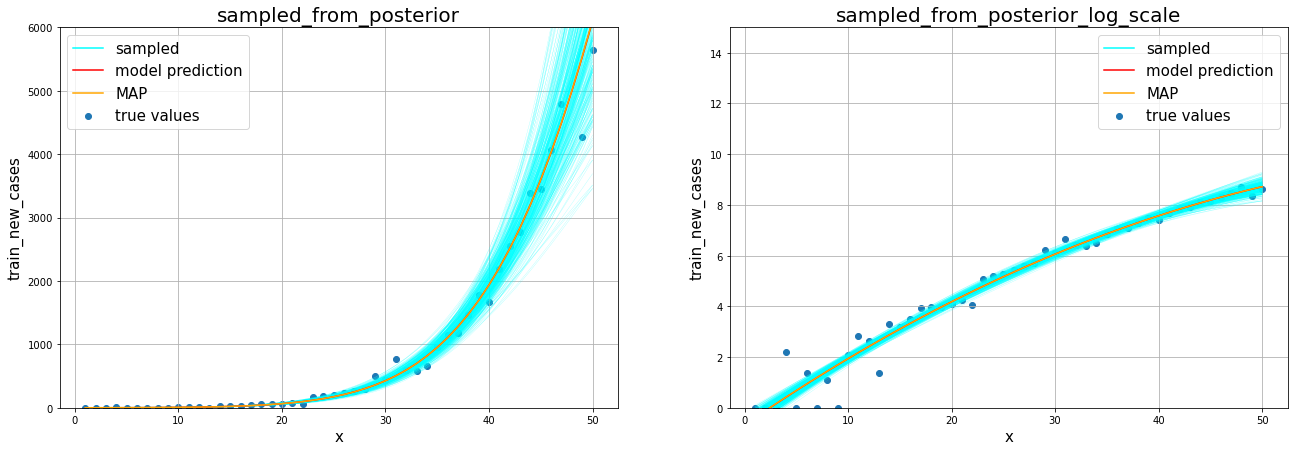

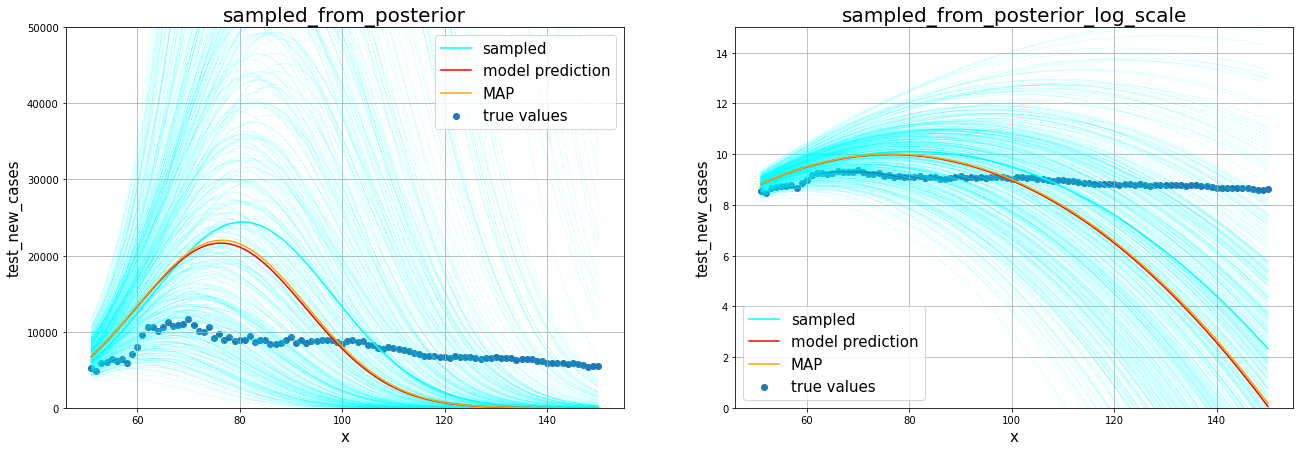

In [35]:
limits = [6e3, 15]
sample_from_posterior_new_cases(post_mu, post_sigma, x_train, new_cases_train, pred_train_sigma, 
                                limits, 'train_new_cases', n=400)
limits = [5e4, 15]
sample_from_posterior_new_cases(post_mu, post_sigma, x_test, new_cases_test, pred_test_sigma, 
                                limits, 'test_new_cases', n=400)

In [36]:
def sample_from_posterior_total_cases(mu, sigma, x, y, pred, limits, title, dates=None, n=20):
    if dates is not None:
        x_axis = dates
    else:
        x_axis = x
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(22, 7))
    for i in range(2):
        if i == 0:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2)), 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2)), 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, y, label='true values')
            ax[i].plot(x_axis, pred, c='r', label='model prediction')
            ax[i].plot(x_axis, np.cumsum(np.exp(mu[0] + mu[1]*x + mu[2]*x**2)), c='orange', label='MAP')
            ax[i].set_ylim(0, limits[0])
            ax[i].set_title('sampled_from_posterior', fontsize=20)
        else:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x_axis, np.log(np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2))), 'aqua', label='sampled')
                else:
                    ax[i].plot(x_axis, np.log(np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2))), 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x_axis, np.log(y), label='true values')
            ax[i].plot(x_axis, np.log(pred), c='r', label='model prediction')
            ax[i].plot(x_axis, np.log(np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2))), c='orange', label='MAP')
            ax[i].set_ylim(0, limits[1])
            ax[i].set_title('sampled_from_posterior_log_scale', fontsize=20)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel(title, fontsize=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)

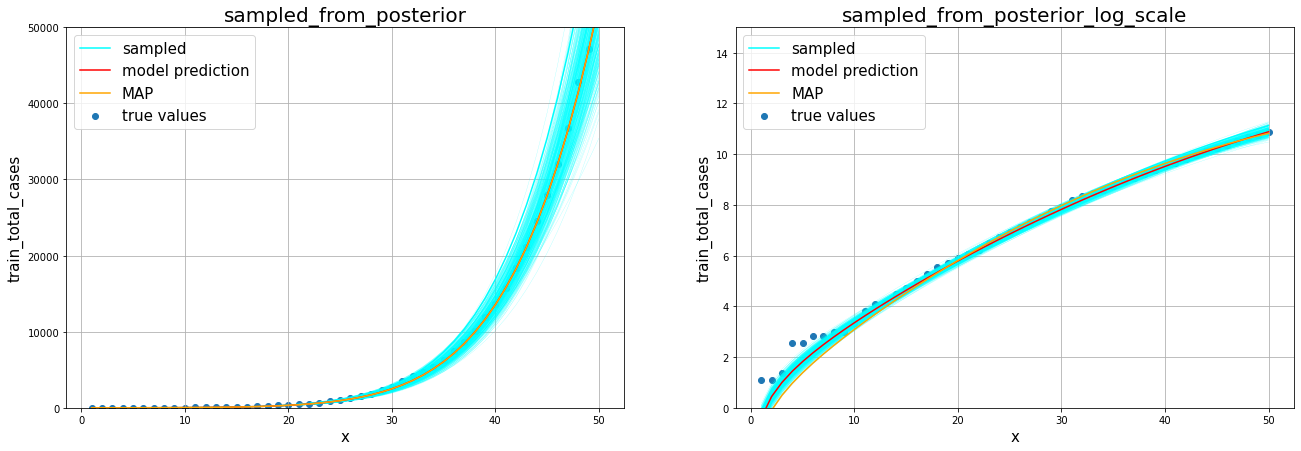

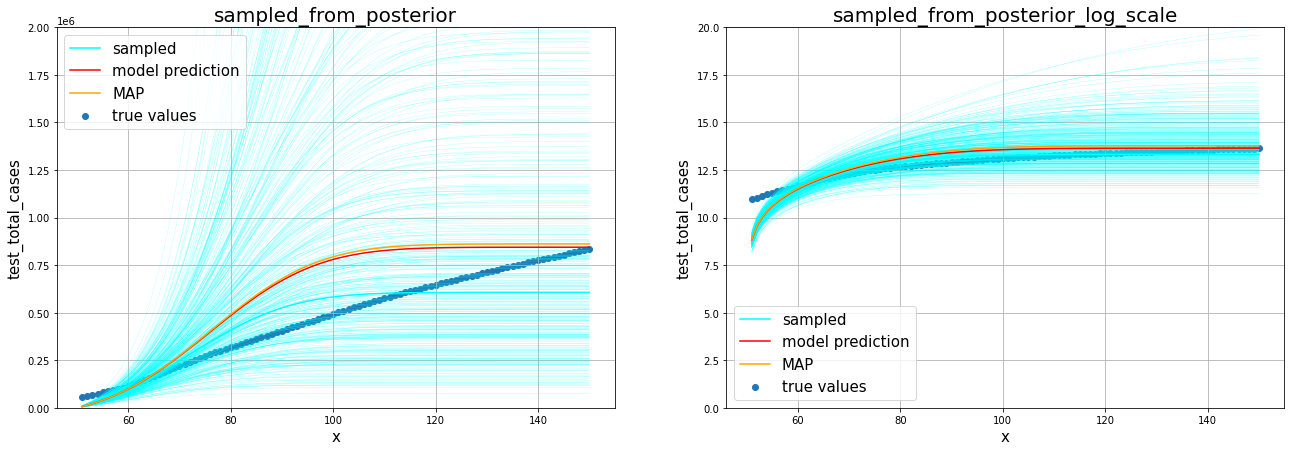

In [37]:
limits = [5e4, 15]
sample_from_posterior_total_cases(post_mu, post_sigma, x_train, total_cases_train, pred_train_sigma_total,
                                  limits, 'train_total_cases', n=400)
limits = [2e6, 20]
sample_from_posterior_total_cases(post_mu, post_sigma, x_test, total_cases_test, pred_test_sigma_total,
                                  limits, 'test_total_cases', n=400)

В результате получаем, что модель достаточно уверенна в своих предсказаниях на трейне, но на тесте возможные значения лежат в широком диапазоне, дисперсия предсказаний высокая. Можно заметить, что для `total_cases` апостериорное распределение похоже на нормальное с длинным хвостом. Рассмотрим это более подробно и построим распределение для конкретного дня. Сделаем прогноз на май/июнь в пессимистичном и оптимистчином сценариях (90-й и 10-й процентили соответственно).

In [38]:
may_id = np.where(dates_test == pd.to_datetime('2020-05-01'))[0][0]
june_id = np.where(dates_test == pd.to_datetime('2020-06-01'))[0][0]

In [39]:
true_may = total_cases_test[may_id]
true_june = total_cases_test[june_id]
may_x = x_test[may_id]
june_x = x_test[june_id]

In [40]:
def sample_total_cases(mu, sigma, x, n):
    samples = []
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        samples.append(np.cumsum(np.exp(w[0] + w[1]*x + w[2]*x**2))[0])
    return np.array(samples)

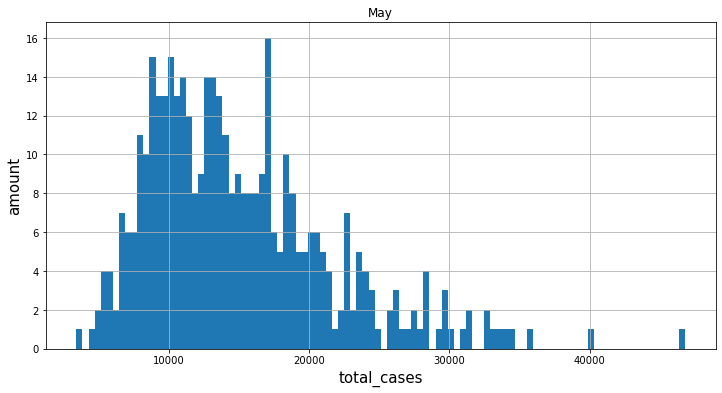

In [41]:
may_samples = sample_total_cases(post_mu, post_sigma, may_x, 400)
plt.figure(figsize=(12, 6))
_ = plt.hist(may_samples, bins=100)
plt.xlabel('total_cases', fontsize=15)
plt.ylabel('amount', fontsize=15)
plt.title('May')
plt.grid()

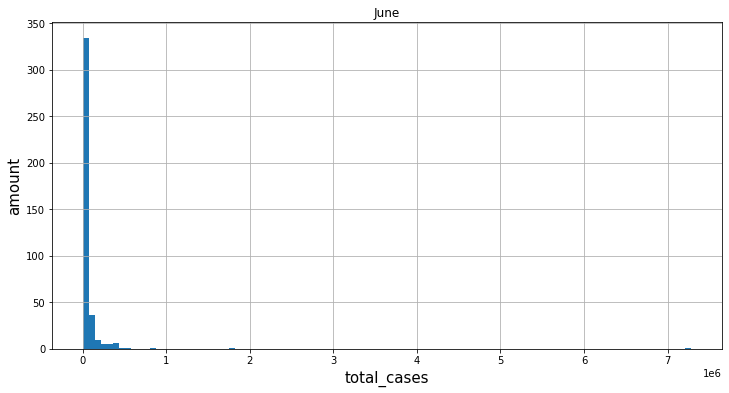

In [42]:
june_samples = sample_total_cases(post_mu, post_sigma, june_x, 400)
plt.figure(figsize=(12, 6))
_ = plt.hist(june_samples, bins=100)
plt.xlabel('total_cases', fontsize=15)
plt.ylabel('amount', fontsize=15)
plt.title('June')
plt.grid()

In [43]:
percentile_90_may, percentile_10_may = np.round(np.percentile(may_samples, [90, 10]))
percentile_90_june, percentile_10_june = np.round(np.percentile(june_samples, [90, 10]))

In [44]:
print('Май')
print(f'Реальное значение: {true_may}')
print(f'Оптимистичный прогноз: {percentile_10_may}')
print(f'Пессимистичный прогноз: {percentile_90_may}\n')

print('Июнь')
print(f'Реальное значение: {true_june}')
print(f'Оптимистичный прогноз: {percentile_10_june}')
print(f'Пессимистичный прогноз: {percentile_90_june}')

Май
Реальное значение: 114431.0
Оптимистичный прогноз: 8111.0
Пессимистичный прогноз: 23785.0

Июнь
Реальное значение: 414328.0
Оптимистичный прогноз: 2037.0
Пессимистичный прогноз: 120092.0


Построив распределения, видно, что для мая оно нормальное с длинным хвостом, а для июня больше похоже на какое-то степенное распределение. Оба прогноза оказались заниженными относительно реальных значений, но гораздо ближе чем в случае экспоненциальной модели.